In [3]:
import geopandas as gpd
import pandas as pd
import numpy as np
rng = np.random.default_rng()

import urllib.request


import matplotlib.pyplot as plt
from multiprocessing import Pool

#### Chargement des données spatiales

In [6]:
urllib.request.urlretrieve('https://minio.lab.sspcloud.fr/h529p3/data/rpg202131.parquet', "sdf.parquet")
sdf = gpd.read_parquet('sdf.parquet')

In [8]:
urllib.request.urlretrieve('https://minio.lab.sspcloud.fr/h529p3/data/DEPARTEMENT.parquet', "departement.parquet")
departement = gpd.read_parquet('departement.parquet')

Calcul de la part batî occupée dans le département (la vraie valeur) : 

In [44]:
sdf_d = gpd.sjoin(departement, sdf) 
sdf_d = sdf.iloc[sdf_d.index_right]
sdf_d = gpd.clip(sdf_d, departement)

Le taux de surface agricole est : 

In [45]:
sdf_d.area.sum() / departement.area.sum() * 100

55.40019906657781

## Sensibilité au choix de l'origine d'une grille régulière

#### Constitution d'une grille régulière

In [14]:
size = 250 # taille de la grille

In [15]:
xmin = np.floor(departement.bounds.minx.values[0]/size) * size - size
xmax = np.ceil(departement.bounds.maxx.values[0]/size) * size + 2 * size
ymin = np.floor(departement.bounds.miny.values[0]/size) * size - size
ymax = np.ceil(departement.bounds.maxy.values[0]/size) * size + size

In [16]:
x = np.arange(xmin,xmax+size,step=size)
y = np.arange(ymin,ymax+size,step=size)
result = np.transpose([np.tile(x, len(y)), np.repeat(y, len(x))])
df = pd.DataFrame(result, columns=['x', 'y'])

#### Calcul de la sensibilité

In [17]:
def calcul_grille(offset):
    grid = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.x+offset[0], df.y+offset[1]), crs="EPSG:2154")
    temp_d = gpd.sjoin(departement, grid)
    temp_b = gpd.sjoin(grid.iloc[temp_d.index_right],sdf_d)
    return([temp_d.shape[0], temp_b.shape[0]])

In [32]:
set_offset = 2 # je décalle la grille de set_offset m en setoffset m 
x_off = np.arange(0,250, set_offset)
y_off = np.arange(0,250, set_offset)
offsets = list(zip(np.tile(x_off,len(y_off)), np.repeat(y_off, len(x_off))))

In [33]:
with Pool(10) as pool: # je paralléliqse les résultats. 
    test = (pool.map(calcul_grille, offsets))

In [ ]:
test = pd.DataFrame(np.array(test), columns=['pts_dep', 'pts_build'])

In [ ]:
test['x_off'] = [offset[0] for offset in offsets]
test['y_off'] = [offset[1] for offset in offsets]

#### Examen des résultats

In [38]:
test['tx_art'] = test.pts_build / test.pts_dep * 100

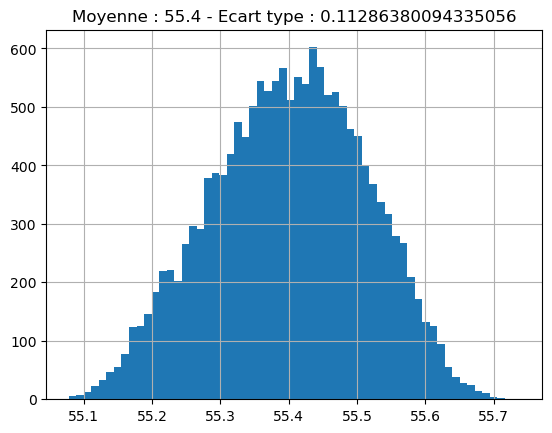

In [39]:
test.hist('tx_art', bins=60)
plt.title('Moyenne : ' + str(np.round(np.mean(test.tx_art),3)) + ' - Ecart type : ' +  str(np.std(test.tx_art)));

In [71]:
test.to_parquet('analyse_2m_agricole_31.csv')